In [47]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision import transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from sklearn.metrics import f1_score, accuracy_score
from models import LSTM
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

In [48]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [50]:
def train(
    model, train_loader, optimizer, criterion,
    valid_loader=None, num_epochs=10
):
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in tqdm(range(num_epochs)):
        model.train()  # 학습 모드
        total_loss = 0
        train_acc_metric = BinaryAccuracy().to(device)

        for data, target in train_loader:
            data, target = data.to(device), target.unsqueeze(dim=1).float().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            prob = torch.sigmoid(output)
            pred = (prob > 0.5).float()
            train_acc_metric.update(pred, target)

        train_avg_loss = total_loss / len(train_loader)
        train_acc = train_acc_metric.compute().item()

        history['train_loss'].append(train_avg_loss)
        history['train_accuracy'].append(train_acc)

        if valid_loader:
            val_loss, _, _, val_acc = validate_model(model, valid_loader, criterion)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(
                f"Epoch {epoch + 1}/{num_epochs} "
                f"| Train Loss: {train_avg_loss:.4f}, Accuracy: {train_acc:.4f} "
                f"| Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}"
            )
        else:
            print(
                f"Epoch {epoch + 1}/{num_epochs} "
                f"| Train Loss: {train_avg_loss:.4f}, Accuracy: {train_acc:.4f}"
            )

    return history


def validate_model(model, test_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0
    actuals = []
    predictions = []

    test_acc_metric = BinaryAccuracy().to(device)

    with torch.no_grad():  # 그라디언트 계산을 비활성화
        for data, target in test_loader:
            data, target = data.to(device), target.unsqueeze(dim=1).float().to(device)
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            total_loss += loss.item()
            
            prob = torch.sigmoid(output)
            pred = (prob > 0.5).float()
            test_acc_metric.update(pred, target)

            # 예측값과 실제값을 리스트에 저장
            actuals.extend(target.squeeze(1).tolist())
            predictions.extend(output.squeeze(1).tolist())

    # 손실 계산
    test_avg_loss = total_loss / len(test_loader)
    test_acc = test_acc_metric.compute().item()

    return test_avg_loss, actuals, predictions, test_acc

In [51]:
dataset = 'pointsCSV'
fight_train_video_names = os.listdir(f'./{dataset}/train/fight/')
fight_val_video_names = os.listdir(f'./{dataset}/val/fight/')
normal_train_video_names = os.listdir(f'./{dataset}/train/normal/')
normal_val_video_names = os.listdir(f'./{dataset}/val/normal/')

fight_train_csv_paths = list(map(lambda x:f'./{dataset}/train/fight/'+x, fight_train_video_names))
fight_val_csv_paths = list(map(lambda x:f'./{dataset}/val/fight/'+x, fight_val_video_names))
normal_train_csv_paths = list(map(lambda x:f'./{dataset}/train/normal/'+x, normal_train_video_names))
normal_val_csv_paths = list(map(lambda x:f'./{dataset}/val/normal/'+x, normal_val_video_names))

In [52]:
len(fight_train_video_names), len(fight_val_video_names), len(normal_train_video_names), len(normal_val_video_names)

(630, 80, 809, 101)

In [53]:
len(fight_train_csv_paths), len(fight_val_csv_paths), len(normal_train_csv_paths), len(normal_val_csv_paths)

(630, 80, 809, 101)

In [54]:
# CSV 파일 경로
csv_path = "./pose_results_3fps.csv"  # <- 여기에 경로 입력

# CSV 파일 불러오기
df = pd.read_csv(csv_path)

# frame 열 제거
data_only = df.drop(columns=['frame'])

# numpy 배열로 변환
data_array = data_only.values
print(data_array.shape)

# (num_frames, 33, 3) 형태로 변환
num_keypoints = 33  # 33개의 키포인트
reshaped = data_array.reshape(-1, num_keypoints, 3)

# torch tensor로 변환
tensor_data = torch.tensor(reshaped, dtype=torch.float32)

print(tensor_data.shape)  # (num_frames, 33, 3)

(180, 99)
torch.Size([180, 33, 3])


In [55]:
# CSV 경로
# csv_path = "./pose_results_3fps.csv"  # ← 파일 경로 입력
csv_path = './pointsCSV_lite/train/fight/'

# CSV 로드
# df = pd.read_csv(csv_path)
df = pd.read_csv(csv_path+os.listdir(csv_path)[0])

# frame 열 제거
data_only = df.drop(columns=['frame'])
if 'video' in data_only.columns:
    data_only = data_only.drop(columns=['video'])

# numpy 배열로 변환
data_array = data_only.values
print(data_array.shape)

# reshape to (num_frames, 33, 3)
all_data = data_array.reshape(-1, 33, 3)  # 33 keypoints, 3 values (x, y, vis)

# torch tensor로 변환
tensor_data = torch.tensor(all_data, dtype=torch.float32)

# 사용할 keypoint 인덱스: [0, 11~32]
selected_indices = list(range(11, 33))

# x 값만 추출 → shape: (num_frames, 23)
x_only_selected = tensor_data[:, selected_indices, 0:2]

print(data_array.shape)
print(x_only_selected.shape)  # (num_frames, 23)

(181, 99)
(181, 99)
torch.Size([181, 22, 2])


In [56]:
def getKeypoints(csv_path):
    df = pd.read_csv(csv_path)

    # frame 열 제거
    data_only = df.drop(columns=['frame'])
    if 'video' in data_only.columns:
        data_only = data_only.drop(columns=['video'])

    # numpy 배열로 변환
    data_array = data_only.values

    # reshape to (num_frames, 33, 3)
    all_data = data_array.reshape(-1, 33, 3)  # 33 keypoints, 3 values (x, y, vis)

    # torch tensor로 변환
    tensor_data = torch.tensor(all_data, dtype=torch.float32)

    # 사용할 keypoint 인덱스: [0, 11~32]
    selected_indices = list(range(11, 33))

    # x 값만 추출 → shape: (num_frames, 23)
    x_only_selected = tensor_data[:, selected_indices, 0:2]
    x_only_selected

    return x_only_selected.reshape([-1, 44])

In [57]:
getKeypoints('./pose_results_3fps.csv').shape

torch.Size([180, 44])

In [58]:
class DS(Dataset):
    def __init__(self, csv_path_list, label_list):
        self.csv_path_list = csv_path_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        points = getKeypoints(self.csv_path_list[index])
        return points[:180, :], self.label_list[index]
        
    def __len__(self):
        return len(self.csv_path_list)

In [59]:
len(fight_train_csv_paths[:500])

500

In [60]:
trainSet = DS(
    fight_train_csv_paths[:630]+fight_val_csv_paths[:70]+normal_train_csv_paths[:700],
    [ 1 for i in range(700)]+[ 0 for i in range(700)]
)

# valSet = DS(
#     fight_val_csv_paths+normal_val_csv_paths,
#     [ 1 for i in fight_val_csv_paths]+[ 0 for i in normal_val_csv_paths]
# )

trainSet, valSet, testSet = random_split(
    trainSet,
    [0.7, 0.2, 0.1],
    torch.Generator().manual_seed(120)
    )

In [61]:
trainSet[0][0].shape

torch.Size([180, 44])

In [62]:
len(trainSet), len(valSet), len(testSet)

(980, 280, 140)

In [63]:
BATCH_SIZE = 32
train_loader = DataLoader(trainSet, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(valSet, batch_size = BATCH_SIZE, shuffle=False, drop_last=True )
test_loader = DataLoader(testSet, batch_size = BATCH_SIZE, shuffle=False, drop_last=True )

In [64]:
# for k, v in train_loader:
    # print(v.dtype)

In [65]:
lstm = LSTM.LSTMmodel(44, 1, 128, 4, 0.3).to(device)
optim = optim.Adam(lstm.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

In [66]:
history = train(lstm, train_loader, optim, criterion, val_loader, 100)

  1%|          | 1/100 [00:12<21:20, 12.93s/it]

Epoch 1/100 | Train Loss: 0.6936, Accuracy: 0.5010 | Val Loss: 0.6926, Accuracy: 0.5039


  2%|▏         | 2/100 [00:25<20:54, 12.81s/it]

Epoch 2/100 | Train Loss: 0.6916, Accuracy: 0.5031 | Val Loss: 0.6887, Accuracy: 0.5039


  3%|▎         | 3/100 [00:38<20:38, 12.77s/it]

Epoch 3/100 | Train Loss: 0.6835, Accuracy: 0.5427 | Val Loss: 0.6709, Accuracy: 0.5977


  4%|▍         | 4/100 [00:51<20:21, 12.72s/it]

Epoch 4/100 | Train Loss: 0.6693, Accuracy: 0.5958 | Val Loss: 0.6642, Accuracy: 0.6172


  5%|▌         | 5/100 [01:03<20:07, 12.71s/it]

Epoch 5/100 | Train Loss: 0.6648, Accuracy: 0.6031 | Val Loss: 0.6551, Accuracy: 0.6172


  6%|▌         | 6/100 [01:17<20:17, 12.96s/it]

Epoch 6/100 | Train Loss: 0.6537, Accuracy: 0.6073 | Val Loss: 0.6458, Accuracy: 0.6133


  7%|▋         | 7/100 [01:29<19:38, 12.67s/it]

Epoch 7/100 | Train Loss: 0.6361, Accuracy: 0.6156 | Val Loss: 0.6234, Accuracy: 0.6484


  8%|▊         | 8/100 [01:42<19:33, 12.76s/it]

Epoch 8/100 | Train Loss: 0.6040, Accuracy: 0.6438 | Val Loss: 0.5899, Accuracy: 0.6641


  9%|▉         | 9/100 [01:55<19:32, 12.88s/it]

Epoch 9/100 | Train Loss: 0.5756, Accuracy: 0.7156 | Val Loss: 0.5838, Accuracy: 0.7422


 10%|█         | 10/100 [02:08<19:26, 12.96s/it]

Epoch 10/100 | Train Loss: 0.5502, Accuracy: 0.7469 | Val Loss: 0.5534, Accuracy: 0.7539


 11%|█         | 11/100 [02:21<19:11, 12.94s/it]

Epoch 11/100 | Train Loss: 0.5143, Accuracy: 0.7583 | Val Loss: 0.5558, Accuracy: 0.7383


 12%|█▏        | 12/100 [02:34<19:08, 13.05s/it]

Epoch 12/100 | Train Loss: 0.5357, Accuracy: 0.7271 | Val Loss: 0.5417, Accuracy: 0.7383


 13%|█▎        | 13/100 [02:47<19:02, 13.14s/it]

Epoch 13/100 | Train Loss: 0.4984, Accuracy: 0.7625 | Val Loss: 0.5203, Accuracy: 0.7539


 14%|█▍        | 14/100 [03:01<19:01, 13.27s/it]

Epoch 14/100 | Train Loss: 0.4517, Accuracy: 0.7729 | Val Loss: 0.4457, Accuracy: 0.8008


 15%|█▌        | 15/100 [03:13<18:24, 13.00s/it]

Epoch 15/100 | Train Loss: 0.4110, Accuracy: 0.7990 | Val Loss: 0.4430, Accuracy: 0.7773


 16%|█▌        | 16/100 [03:26<17:52, 12.76s/it]

Epoch 16/100 | Train Loss: 0.4806, Accuracy: 0.7417 | Val Loss: 0.5015, Accuracy: 0.7578


 17%|█▋        | 17/100 [03:37<17:10, 12.42s/it]

Epoch 17/100 | Train Loss: 0.4392, Accuracy: 0.7885 | Val Loss: 0.4836, Accuracy: 0.7578


 18%|█▊        | 18/100 [03:49<16:49, 12.31s/it]

Epoch 18/100 | Train Loss: 0.3930, Accuracy: 0.7990 | Val Loss: 0.3612, Accuracy: 0.8438


 19%|█▉        | 19/100 [04:01<16:19, 12.09s/it]

Epoch 19/100 | Train Loss: 0.4530, Accuracy: 0.7573 | Val Loss: 0.4439, Accuracy: 0.8086


 20%|██        | 20/100 [04:12<15:50, 11.88s/it]

Epoch 20/100 | Train Loss: 0.3892, Accuracy: 0.8062 | Val Loss: 0.4406, Accuracy: 0.7930


 21%|██        | 21/100 [04:24<15:29, 11.77s/it]

Epoch 21/100 | Train Loss: 0.3708, Accuracy: 0.8062 | Val Loss: 0.7635, Accuracy: 0.7461


 22%|██▏       | 22/100 [04:36<15:18, 11.77s/it]

Epoch 22/100 | Train Loss: 0.3946, Accuracy: 0.8135 | Val Loss: 0.3881, Accuracy: 0.8281


 23%|██▎       | 23/100 [04:47<15:05, 11.76s/it]

Epoch 23/100 | Train Loss: 0.3286, Accuracy: 0.8594 | Val Loss: 0.3925, Accuracy: 0.8672


 24%|██▍       | 24/100 [05:00<15:12, 12.01s/it]

Epoch 24/100 | Train Loss: 0.4136, Accuracy: 0.8167 | Val Loss: 0.4461, Accuracy: 0.7891


 25%|██▌       | 25/100 [05:12<15:09, 12.12s/it]

Epoch 25/100 | Train Loss: 0.3645, Accuracy: 0.8260 | Val Loss: 0.4917, Accuracy: 0.8047


 26%|██▌       | 26/100 [05:24<14:40, 11.89s/it]

Epoch 26/100 | Train Loss: 0.4073, Accuracy: 0.7906 | Val Loss: 0.4642, Accuracy: 0.7656


 27%|██▋       | 27/100 [05:35<14:10, 11.65s/it]

Epoch 27/100 | Train Loss: 0.3786, Accuracy: 0.8167 | Val Loss: 0.3976, Accuracy: 0.8281


 28%|██▊       | 28/100 [05:47<14:15, 11.88s/it]

Epoch 28/100 | Train Loss: 0.3485, Accuracy: 0.8375 | Val Loss: 0.3346, Accuracy: 0.8711


 29%|██▉       | 29/100 [06:00<14:20, 12.12s/it]

Epoch 29/100 | Train Loss: 0.5243, Accuracy: 0.8104 | Val Loss: 0.3321, Accuracy: 0.8828


 30%|███       | 30/100 [06:12<14:03, 12.05s/it]

Epoch 30/100 | Train Loss: 0.3179, Accuracy: 0.8625 | Val Loss: 0.3273, Accuracy: 0.8750


 31%|███       | 31/100 [06:25<14:09, 12.32s/it]

Epoch 31/100 | Train Loss: 0.2855, Accuracy: 0.8927 | Val Loss: 0.2888, Accuracy: 0.9023


 32%|███▏      | 32/100 [06:37<13:51, 12.22s/it]

Epoch 32/100 | Train Loss: 0.3417, Accuracy: 0.8708 | Val Loss: 1.4850, Accuracy: 0.5508


 33%|███▎      | 33/100 [06:49<13:42, 12.28s/it]

Epoch 33/100 | Train Loss: 0.7705, Accuracy: 0.7042 | Val Loss: 0.5153, Accuracy: 0.7734


 34%|███▍      | 34/100 [07:00<13:12, 12.01s/it]

Epoch 34/100 | Train Loss: 0.4176, Accuracy: 0.8094 | Val Loss: 0.3819, Accuracy: 0.8438


 35%|███▌      | 35/100 [07:13<13:02, 12.04s/it]

Epoch 35/100 | Train Loss: 0.3467, Accuracy: 0.8510 | Val Loss: 0.4031, Accuracy: 0.8203


 36%|███▌      | 36/100 [07:25<12:52, 12.07s/it]

Epoch 36/100 | Train Loss: 0.3118, Accuracy: 0.8635 | Val Loss: 0.3159, Accuracy: 0.8633


 37%|███▋      | 37/100 [07:37<12:35, 11.99s/it]

Epoch 37/100 | Train Loss: 0.2568, Accuracy: 0.8844 | Val Loss: 0.2511, Accuracy: 0.9102


 38%|███▊      | 38/100 [07:49<12:24, 12.00s/it]

Epoch 38/100 | Train Loss: 0.2575, Accuracy: 0.8958 | Val Loss: 0.2793, Accuracy: 0.9023


 39%|███▉      | 39/100 [08:00<11:55, 11.74s/it]

Epoch 39/100 | Train Loss: 0.2432, Accuracy: 0.9073 | Val Loss: 0.2277, Accuracy: 0.9219


 40%|████      | 40/100 [08:12<11:50, 11.84s/it]

Epoch 40/100 | Train Loss: 0.2149, Accuracy: 0.9250 | Val Loss: 0.2466, Accuracy: 0.9180


 41%|████      | 41/100 [08:23<11:21, 11.55s/it]

Epoch 41/100 | Train Loss: 0.2317, Accuracy: 0.9177 | Val Loss: 0.2709, Accuracy: 0.9023


 42%|████▏     | 42/100 [08:34<11:02, 11.43s/it]

Epoch 42/100 | Train Loss: 0.2276, Accuracy: 0.9177 | Val Loss: 0.2446, Accuracy: 0.9219


 43%|████▎     | 43/100 [08:45<10:56, 11.52s/it]

Epoch 43/100 | Train Loss: 0.2097, Accuracy: 0.9260 | Val Loss: 0.2245, Accuracy: 0.9258


 44%|████▍     | 44/100 [08:57<10:43, 11.50s/it]

Epoch 44/100 | Train Loss: 0.1956, Accuracy: 0.9281 | Val Loss: 0.2048, Accuracy: 0.9336


 45%|████▌     | 45/100 [09:08<10:31, 11.49s/it]

Epoch 45/100 | Train Loss: 0.2023, Accuracy: 0.9229 | Val Loss: 0.2144, Accuracy: 0.9102


 46%|████▌     | 46/100 [09:20<10:24, 11.56s/it]

Epoch 46/100 | Train Loss: 0.1841, Accuracy: 0.9292 | Val Loss: 0.1912, Accuracy: 0.9297


 47%|████▋     | 47/100 [09:31<10:04, 11.40s/it]

Epoch 47/100 | Train Loss: 0.1751, Accuracy: 0.9365 | Val Loss: 0.1943, Accuracy: 0.9258


 48%|████▊     | 48/100 [09:43<09:57, 11.50s/it]

Epoch 48/100 | Train Loss: 0.1819, Accuracy: 0.9302 | Val Loss: 0.1904, Accuracy: 0.9297


 49%|████▉     | 49/100 [09:55<09:54, 11.65s/it]

Epoch 49/100 | Train Loss: 0.1755, Accuracy: 0.9333 | Val Loss: 0.2101, Accuracy: 0.9258


 50%|█████     | 50/100 [10:06<09:38, 11.57s/it]

Epoch 50/100 | Train Loss: 0.1863, Accuracy: 0.9333 | Val Loss: 0.2178, Accuracy: 0.9258


 51%|█████     | 51/100 [10:17<09:18, 11.40s/it]

Epoch 51/100 | Train Loss: 0.1688, Accuracy: 0.9323 | Val Loss: 0.1927, Accuracy: 0.9375


 52%|█████▏    | 52/100 [10:29<09:09, 11.45s/it]

Epoch 52/100 | Train Loss: 0.1594, Accuracy: 0.9396 | Val Loss: 0.2003, Accuracy: 0.9336


 53%|█████▎    | 53/100 [10:40<08:57, 11.44s/it]

Epoch 53/100 | Train Loss: 0.1752, Accuracy: 0.9385 | Val Loss: 0.1956, Accuracy: 0.9375


 54%|█████▍    | 54/100 [10:53<08:58, 11.71s/it]

Epoch 54/100 | Train Loss: 0.1713, Accuracy: 0.9354 | Val Loss: 0.1820, Accuracy: 0.9453


 55%|█████▌    | 55/100 [11:04<08:44, 11.66s/it]

Epoch 55/100 | Train Loss: 0.1611, Accuracy: 0.9385 | Val Loss: 0.1830, Accuracy: 0.9336


 56%|█████▌    | 56/100 [11:16<08:38, 11.77s/it]

Epoch 56/100 | Train Loss: 0.1834, Accuracy: 0.9271 | Val Loss: 0.2020, Accuracy: 0.9258


 57%|█████▋    | 57/100 [11:28<08:22, 11.69s/it]

Epoch 57/100 | Train Loss: 0.1590, Accuracy: 0.9469 | Val Loss: 0.2006, Accuracy: 0.9375


 58%|█████▊    | 58/100 [11:39<08:12, 11.72s/it]

Epoch 58/100 | Train Loss: 0.1489, Accuracy: 0.9510 | Val Loss: 0.2012, Accuracy: 0.9336


 59%|█████▉    | 59/100 [11:51<08:00, 11.71s/it]

Epoch 59/100 | Train Loss: 0.2235, Accuracy: 0.9208 | Val Loss: 0.2382, Accuracy: 0.9141


 60%|██████    | 60/100 [12:03<07:48, 11.70s/it]

Epoch 60/100 | Train Loss: 0.1480, Accuracy: 0.9490 | Val Loss: 0.2145, Accuracy: 0.9297


 61%|██████    | 61/100 [12:15<07:40, 11.80s/it]

Epoch 61/100 | Train Loss: 0.1469, Accuracy: 0.9438 | Val Loss: 0.1746, Accuracy: 0.9492


 62%|██████▏   | 62/100 [12:27<07:36, 12.02s/it]

Epoch 62/100 | Train Loss: 0.1402, Accuracy: 0.9458 | Val Loss: 0.1773, Accuracy: 0.9336


 63%|██████▎   | 63/100 [12:40<07:27, 12.10s/it]

Epoch 63/100 | Train Loss: 0.2785, Accuracy: 0.9167 | Val Loss: 0.1559, Accuracy: 0.9531


 64%|██████▍   | 64/100 [12:52<07:17, 12.15s/it]

Epoch 64/100 | Train Loss: 0.2155, Accuracy: 0.9156 | Val Loss: 0.3279, Accuracy: 0.8633


 65%|██████▌   | 65/100 [13:05<07:15, 12.44s/it]

Epoch 65/100 | Train Loss: 0.2400, Accuracy: 0.8958 | Val Loss: 0.2353, Accuracy: 0.9141


 66%|██████▌   | 66/100 [13:21<07:38, 13.48s/it]

Epoch 66/100 | Train Loss: 0.1696, Accuracy: 0.9375 | Val Loss: 0.1888, Accuracy: 0.9375


 67%|██████▋   | 67/100 [14:05<12:22, 22.51s/it]

Epoch 67/100 | Train Loss: 0.1265, Accuracy: 0.9646 | Val Loss: 0.1595, Accuracy: 0.9609


 68%|██████▊   | 68/100 [14:47<15:07, 28.36s/it]

Epoch 68/100 | Train Loss: 0.1699, Accuracy: 0.9427 | Val Loss: 0.1608, Accuracy: 0.9453


 69%|██████▉   | 69/100 [15:27<16:31, 31.99s/it]

Epoch 69/100 | Train Loss: 0.1376, Accuracy: 0.9594 | Val Loss: 0.1568, Accuracy: 0.9492


 70%|███████   | 70/100 [16:09<17:31, 35.03s/it]

Epoch 70/100 | Train Loss: 0.1433, Accuracy: 0.9500 | Val Loss: 0.2732, Accuracy: 0.8906


 71%|███████   | 71/100 [16:52<18:03, 37.38s/it]

Epoch 71/100 | Train Loss: 0.1773, Accuracy: 0.9323 | Val Loss: 0.2014, Accuracy: 0.9141


 72%|███████▏  | 72/100 [17:32<17:50, 38.24s/it]

Epoch 72/100 | Train Loss: 0.1702, Accuracy: 0.9312 | Val Loss: 0.2062, Accuracy: 0.9258


 73%|███████▎  | 73/100 [18:07<16:40, 37.05s/it]

Epoch 73/100 | Train Loss: 0.1414, Accuracy: 0.9521 | Val Loss: 0.1544, Accuracy: 0.9570


 74%|███████▍  | 74/100 [18:37<15:15, 35.20s/it]

Epoch 74/100 | Train Loss: 0.1129, Accuracy: 0.9604 | Val Loss: 0.1580, Accuracy: 0.9570


 75%|███████▌  | 75/100 [19:10<14:23, 34.56s/it]

Epoch 75/100 | Train Loss: 0.1046, Accuracy: 0.9604 | Val Loss: 0.1507, Accuracy: 0.9531


 76%|███████▌  | 76/100 [19:42<13:26, 33.59s/it]

Epoch 76/100 | Train Loss: 0.3047, Accuracy: 0.8635 | Val Loss: 0.3057, Accuracy: 0.8633


 77%|███████▋  | 77/100 [20:13<12:36, 32.87s/it]

Epoch 77/100 | Train Loss: 0.2130, Accuracy: 0.9062 | Val Loss: 0.2546, Accuracy: 0.9062


 78%|███████▊  | 78/100 [20:43<11:44, 32.02s/it]

Epoch 78/100 | Train Loss: 0.1613, Accuracy: 0.9323 | Val Loss: 0.2030, Accuracy: 0.9375


 79%|███████▉  | 79/100 [21:14<11:03, 31.58s/it]

Epoch 79/100 | Train Loss: 0.1438, Accuracy: 0.9458 | Val Loss: 0.2082, Accuracy: 0.9297


 80%|████████  | 80/100 [21:32<09:13, 27.68s/it]

Epoch 80/100 | Train Loss: 0.1234, Accuracy: 0.9573 | Val Loss: 0.1639, Accuracy: 0.9492


 81%|████████  | 81/100 [21:45<07:22, 23.27s/it]

Epoch 81/100 | Train Loss: 0.1072, Accuracy: 0.9604 | Val Loss: 0.1518, Accuracy: 0.9492


 82%|████████▏ | 82/100 [21:58<06:02, 20.12s/it]

Epoch 82/100 | Train Loss: 0.1164, Accuracy: 0.9625 | Val Loss: 0.1848, Accuracy: 0.9375


 83%|████████▎ | 83/100 [22:10<05:00, 17.70s/it]

Epoch 83/100 | Train Loss: 0.1049, Accuracy: 0.9667 | Val Loss: 0.1207, Accuracy: 0.9609


 84%|████████▍ | 84/100 [22:23<04:19, 16.19s/it]

Epoch 84/100 | Train Loss: 0.0791, Accuracy: 0.9729 | Val Loss: 0.1157, Accuracy: 0.9688


 85%|████████▌ | 85/100 [22:34<03:43, 14.87s/it]

Epoch 85/100 | Train Loss: 0.0744, Accuracy: 0.9781 | Val Loss: 0.1098, Accuracy: 0.9688


 86%|████████▌ | 86/100 [22:47<03:19, 14.22s/it]

Epoch 86/100 | Train Loss: 0.0658, Accuracy: 0.9740 | Val Loss: 0.0930, Accuracy: 0.9766


 87%|████████▋ | 87/100 [22:59<02:56, 13.59s/it]

Epoch 87/100 | Train Loss: 0.0709, Accuracy: 0.9802 | Val Loss: 0.1083, Accuracy: 0.9648


 88%|████████▊ | 88/100 [23:12<02:38, 13.19s/it]

Epoch 88/100 | Train Loss: 0.0681, Accuracy: 0.9781 | Val Loss: 0.1014, Accuracy: 0.9727


 89%|████████▉ | 89/100 [23:24<02:22, 13.00s/it]

Epoch 89/100 | Train Loss: 0.0725, Accuracy: 0.9760 | Val Loss: 0.1191, Accuracy: 0.9609


 90%|█████████ | 90/100 [23:36<02:07, 12.79s/it]

Epoch 90/100 | Train Loss: 0.0680, Accuracy: 0.9771 | Val Loss: 0.0971, Accuracy: 0.9727


 91%|█████████ | 91/100 [23:49<01:54, 12.67s/it]

Epoch 91/100 | Train Loss: 0.1052, Accuracy: 0.9677 | Val Loss: 0.1349, Accuracy: 0.9492


 92%|█████████▏| 92/100 [24:02<01:43, 12.98s/it]

Epoch 92/100 | Train Loss: 0.0869, Accuracy: 0.9750 | Val Loss: 0.1111, Accuracy: 0.9609


 93%|█████████▎| 93/100 [24:13<01:25, 12.16s/it]

Epoch 93/100 | Train Loss: 0.0707, Accuracy: 0.9802 | Val Loss: 0.1062, Accuracy: 0.9648


 94%|█████████▍| 94/100 [24:21<01:06, 11.05s/it]

Epoch 94/100 | Train Loss: 0.0686, Accuracy: 0.9771 | Val Loss: 0.1099, Accuracy: 0.9648


 95%|█████████▌| 95/100 [24:30<00:51, 10.27s/it]

Epoch 95/100 | Train Loss: 0.0586, Accuracy: 0.9812 | Val Loss: 0.1108, Accuracy: 0.9609


 96%|█████████▌| 96/100 [24:38<00:38,  9.75s/it]

Epoch 96/100 | Train Loss: 0.0551, Accuracy: 0.9833 | Val Loss: 0.1215, Accuracy: 0.9570


 97%|█████████▋| 97/100 [24:47<00:28,  9.38s/it]

Epoch 97/100 | Train Loss: 0.0677, Accuracy: 0.9792 | Val Loss: 0.1242, Accuracy: 0.9570


 98%|█████████▊| 98/100 [24:55<00:18,  9.08s/it]

Epoch 98/100 | Train Loss: 0.0632, Accuracy: 0.9792 | Val Loss: 0.1473, Accuracy: 0.9531


 99%|█████████▉| 99/100 [25:03<00:08,  8.85s/it]

Epoch 99/100 | Train Loss: 0.0615, Accuracy: 0.9771 | Val Loss: 0.1246, Accuracy: 0.9531


100%|██████████| 100/100 [25:12<00:00, 15.12s/it]

Epoch 100/100 | Train Loss: 0.0557, Accuracy: 0.9792 | Val Loss: 0.1187, Accuracy: 0.9570


In [67]:
result_train = validate_model(lstm, train_loader, criterion)
result_val = validate_model(lstm, val_loader, criterion)
result_test = validate_model(lstm, test_loader, criterion)

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluation_model(result):
    # 1) actuals, predictions는 리스트 형태이므로 numpy array로 변환
    y_true = np.array(result[1])             # ex) [0., 1., 1., 0., ...]
    logits = np.array(result[2])         # ex) [ 2.3, -0.5, 0.8, ... ]

    # 2) 로짓 → 확률로 변환 (sigmoid)
    probs = 1 / (1 + np.exp(-logits))      # shape: (n_samples,)

    # 3) 확률 → 이진 예측 (threshold = 0.5)
    y_pred = (probs >= 0.5).astype(int)     # 0 또는 1

    # 4) 정수형 actuals
    y_true_int = y_true.astype(int)

    # 5) sklearn으로 지표 계산
    acc  = accuracy_score(y_true_int, y_pred)
    prec = precision_score(y_true_int, y_pred)
    rec  = recall_score(y_true_int, y_pred)
    f1   = f1_score(y_true_int, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")



In [69]:
print('Train set')
evaluation_model(result_train)
print('Validation set')
evaluation_model(result_val)
print('Test set')
evaluation_model(result_test)

Train set
Accuracy : 0.9854
Precision: 0.9874
Recall   : 0.9833
F1-score : 0.9854
Validation set
Accuracy : 0.9570
Precision: 0.9603
Recall   : 0.9528
F1-score : 0.9565
Test set
Accuracy : 0.9688
Precision: 0.9706
Recall   : 0.9706
F1-score : 0.9706


In [70]:
sample_csv = getKeypoints('./pose_results_3fps.csv')
sample_csv.shape

torch.Size([180, 44])

In [71]:
sample_result_lstm = lstm(sample_csv.unsqueeze(dim=0).to(device))

In [72]:
type(sample_result_lstm)

torch.Tensor

In [73]:
probs = 1 / (1 + np.exp(-np.array(sample_result_lstm.item())))
probs

0.9849376821151861

In [74]:
sample_csv = getKeypoints('./pose_results_3fps2.csv')
sample_csv.shape

torch.Size([901, 44])

In [75]:
sample_result_lstm = lstm(sample_csv.unsqueeze(dim=0).to(device))
probs = 1 / (1 + np.exp(-np.array(sample_result_lstm.item())))
1 - probs

0.9962735074971727

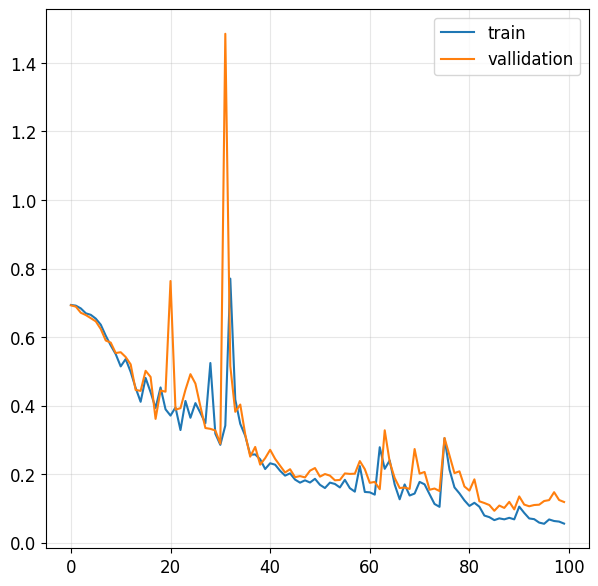

In [76]:
plt.figure(figsize=(7,7))
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.legend(['train', 'vallidation'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

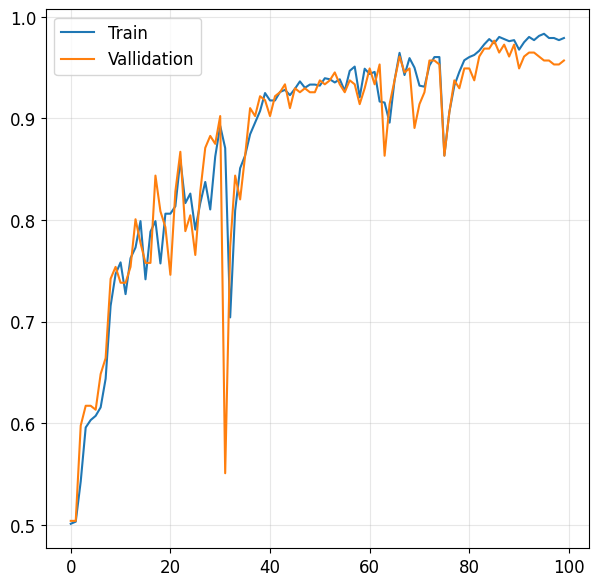

In [77]:
plt.figure(figsize=(7,7))
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('')
plt.legend(['Train', 'Vallidation'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.show()